In [ ]:
import os
from PIL import Image
import numpy as np

folder_path = r'C:\Users\OptiSAR\Desktop\chunks photo\All_real_image - Copy'
image_size = (16, 16)
image_arrays = []

for filename in os.listdir(folder_path):
    if filename.endswith(".tif"): 
        img_path = os.path.join(folder_path, filename)  
        img = Image.open(img_path) 
        img = img.resize(image_size) 
        img_array = np.array(img) 
        img_array = img_array / 255.0  # Normalize to [0, 1]

        if img_array.ndim == 2:  
            img_array = img_array[..., np.newaxis]  # 

        image_arrays.append(img_array)  

load_data = np.array(image_arrays)

In [175]:
load_data.dtype

dtype('float32')

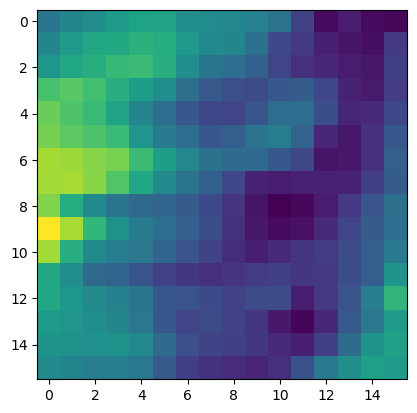

In [177]:
import matplotlib.pyplot as plt
plt.imshow(load_data[3])

In [179]:
load_data.shape

(5750, 16, 16, 1)

In [181]:
load_data.dtype

dtype('float32')

In [183]:
from sklearn.model_selection import train_test_split
labels = np.random.randint(0, 16, size=(load_data.shape[0],))
trainX, testX, trainy, testy = train_test_split(load_data,labels, test_size=0.2, random_state=42)

In [185]:
trainX.shape

(4600, 16, 16, 1)

In [187]:
def load_real_samples():
    x = trainX.astype('float32')
    x = (x-127.5)/127.5
    return x

In [189]:
dataset = load_real_samples()

In [191]:
def generate_real_samples(dataset,n_samples):
    ix = np.random.randint(0,dataset.shape[0],n_samples)
    x=dataset[ix]
    y=np.ones((n_samples,1))
    return x,y

In [193]:
n_samples = 30
x,y = generate_real_samples(dataset,n_samples)

In [195]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, Flatten, Conv2D, Conv2DTranspose
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Reshape, Activation
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Dropout,Input
from tensorflow.keras.activations import gelu



def define_discriminator():
    model = Sequential()
    
    
    model.add(Conv2D(64, kernel_size=3, padding='same', input_shape=(16, 16, 1)))
    model.add(Activation(gelu))
    
    
    model.add(Conv2DTranspose(3, kernel_size=3, strides=2, padding='same'))
    model.add(Activation(gelu))
    resnet50 = ResNet50(include_top=False, weights='imagenet', input_shape=(32, 32, 3))
    for layer in resnet50.layers:
        layer.trainable = False  
    model.add(resnet50)
    
    model.add(Flatten())
    
    model.add(Dense(1024, activation=gelu))
    model.add(Dropout(0.5))  
    
    model.add(Dense(512, activation=gelu))  
    model.add(Dropout(0.5))
    
    model.add(Dense(256, activation=gelu))
    
    model.add(Dense(1, activation='sigmoid'))
    
    opt = Adam(learning_rate=0.0002, beta_1=0.5)  
    
    
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    
    return model



In [197]:
d_model = define_discriminator()
d_model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)                    │ (None, 16, 16, 64)          │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_6 (Activation)            │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_3 (Conv2DTranspose) │ (None, 32, 32, 3)           │           1,731 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_7 (Activation)            │ (None, 32, 32, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ resnet50 (Functional)                │ (None, 1, 1, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 1024)                │       2,098,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 26,344,644 (100.50 MB)

 Trainable params: 2,756,932 (10.52 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [199]:
def define_generator():
    model = Sequential()


    model.add(Conv2D(64, kernel_size=3, padding='same', input_shape=(16, 16, 1)))
    model.add(Activation(gelu))
    
    model.add(Conv2DTranspose(3, kernel_size=3, strides=2, padding='same'))
    model.add(Activation(gelu))
    
    
    resnet50 = ResNet50(include_top=False, weights='imagenet', input_shape=(32, 32, 3))
    for layer in resnet50.layers:
        layer.trainable = False  # Freeze ResNet50 layers to leverage pre-trained weights
    model.add(resnet50)
    
    model.add(Flatten())
    
    model.add(Dense(1024, activation=gelu))
    model.add(Dense(512, activation=gelu))  
    model.add(Dense(256, activation=gelu))
    
   
    model.add(Reshape((16, 16, 1)))
    
    model.add(Conv2D(1, kernel_size=3, padding='same', activation='tanh'))
    
    model.compile(optimizer=Adam(learning_rate=0.0002, beta_1=0.5), loss='binary_crossentropy')
    
    return model

In [201]:
g_model = define_generator()
g_model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)                    │ (None, 16, 16, 64)          │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_8 (Activation)            │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_4 (Conv2DTranspose) │ (None, 32, 32, 3)           │           1,731 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_9 (Activation)            │ (None, 32, 32, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ resnet50 (Functional)                │ (None, 1, 1, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 1024)                │       2,098,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_2 (Reshape)                  │ (None, 16, 16, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 16, 16, 1)           │              10 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 26,344,397 (100.50 MB)

 Trainable params: 2,756,685 (10.52 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [29]:
import os
from PIL import Image
import numpy as np

folder_path = r'C:\Users\OptiSAR\Desktop\chunks photo\Modified image - Copy'
image_size = (16, 16)
image_arrays = []

for filename in os.listdir(folder_path):
    if filename.endswith(".tif"): 
        img_path = os.path.join(folder_path, filename)  
        img = Image.open(img_path) 
        img = img.resize(image_size) 
        img_array = np.array(img) 
        img_array = img_array / 255.0  # Normalize to [0, 1]

        if img_array.ndim == 2:  
            img_array = img_array[..., np.newaxis]  # 

        image_arrays.append(img_array)  
modified_data = np.array(image_arrays)

In [30]:
modified_data.dtype

dtype('float32')

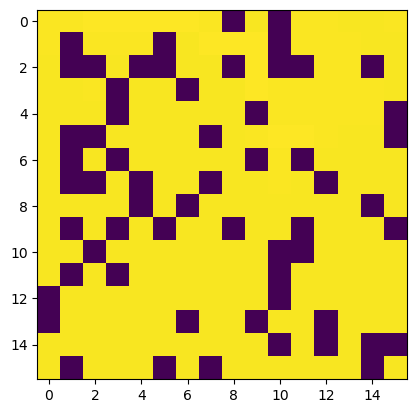

In [31]:
plt.imshow(modified_data[79])

In [35]:
def generate_fake_samples(g_model, modified_data):
    
    x = g_model.predict(modified_data)
    return x


In [37]:
g_model = define_generator()
x = generate_fake_samples(g_model,modified_data)

NameError: name 'define_generator' is not defined

In [215]:
x.shape

(4600, 16, 16, 1)

In [217]:
x.dtype

dtype('float32')

In [219]:
# def generate_fake_samples(g_model, modified_data):
#     x= g_model.predict(modified_data)
#     return x

In [221]:
# x = generate_fake_samples(g_model, modified_data)

In [223]:
def define_gan(g_model,d_model):
    d_model.trainable=False
    model=Sequential()
    model.add(g_model)
    model.add(d_model)
    opt=Adam(learning_rate=0.0002,beta_1=0.5)
    model.compile(loss="binary_crossentropy",optimizer=opt)
    return model

In [225]:
gan_model= define_gan(g_model,d_model)

In [227]:
gan_model.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_6 (Sequential)            │ (None, 16, 16, 1)           │      26,344,397 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_4 (Sequential)            │ (None, 1)                   │      26,344,644 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 52,689,041 (200.99 MB)

 Trainable params: 2,756,685 (10.52 MB)

 Non-trainable params: 49,932,356 (190.48 MB)

In [231]:

def train(g_model, d_model, gan_model, modified_data ,dataset, n_epochs=15, n_batch=64):
    bat_per_epo = int(dataset.shape[0] / n_batch)
    half_batch = modified_data[:50][:int(n_batch/2)]
    for i in range(n_epochs): 
        for j in range(bat_per_epo):
            
            X_real, y_real = generate_real_samples(dataset, half_batch.shape[0] ) 
            d_loss1 = d_model.train_on_batch(X_real, y_real)
            X_fake, y_fake = generate_fake_samples(g_model, half_batch), np.zeros((half_batch.shape[0], 1))
            d_loss2 = d_model.train_on_batch(X_fake, y_fake)
            X_gan, y_gan = generate_fake_samples(g_model, half_batch), np.ones((half_batch.shape[0], 1))
            g_loss = gan_model.train_on_batch(X_gan, y_gan)
            
            print(f'd_loss1: {d_loss1}, d_loss2: {d_loss2}, g_loss: {g_loss}')
        
        if (i+1) % 10 == 0:
            summarize_performance(i, g_model, d_model, dataset, half_batch.shape[0])

In [233]:
# 
# def train(g_model, d_model, gan_model, modified_data ,dataset, n_epochs=2, n_batch=64):
#     bat_per_epo = int(dataset.shape[0] / n_batch)
#     half_batch = modified_data[:50][:int(n_batch/2)]
#     for i in range(n_epochs): 
#         for j in range(bat_per_epo):
            
#             X_real, y_real = generate_real_samples(dataset, half_batch.shape[0] ) #
#             d_loss1 = d_model.train_on_batch(X_real, y_real)
#             X_fake, y_fake = generate_fake_samples(g_model, half_batch), np.zeros((half_batch.shape[0], 1))#half_batch
#             d_loss2 = d_model.train_on_batch(X_fake, y_fake)
#             X_gan, y_gan = generate_fake_samples(g_model, half_batch), np.ones((half_batch.shape[0], 1))
#             g_loss = gan_model.train_on_batch(X_gan, y_gan)
            
#             print(f'd_loss1: {d_loss1}, d_loss2: {d_loss2}, g_loss: {g_loss}')
        
#         if (i+1) % 10 == 0:
#             summarize_performance(i, g_model, d_model, dataset, half_batch.shape[0])

In [235]:
def summarize_performance(epoch, g_model, d_model, dataset,n_samples=64):
    X_real, y_real = generate_real_samples(dataset,n_samples) 
    _, acc_real = d_model.evaluate(X_real, y_real, verbose=0)
    X_fake, y_fake = generate_fake_samples(g_model,n_samples) 
    _, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0)
    print('>Accuracy real: %.0f%%, fake: %.0f%%' % (acc_real*100, acc_fake*100))
    save_plot(X_fake,epoch)
    filename = os.path.join(r'C:\Users\OptiSAR\Desktop\gan\save_image', "generate_model_%03d.h5" % (epoch+1))
    g_model.save(filename)

In [237]:
from matplotlib import pyplot
save_dir=r'C:\Users\OptiSAR\Desktop\gan\save image'
def save_plot(examples, epoch, n=7, save_dir=save_dir):
    # Normalize the images
    examples = (examples + 1) / 2.0
    if not os.path.exist(save_dir):
        os.makedirs(save_dir)
    for i in range(n * n):
        pyplot.subplot(n, n, 1 + i)
        pyplot.axis('off')
        pyplot.imshow(examples[i])
    filename = os.path.join(save_dir, 'generated_plot_e%03d.tif' % (epoch+1))
    pyplot.savefig(filename, format='tif')
    pyplot.close()

In [239]:
train(g_model, d_model, gan_model, dataset, modified_data, n_epochs=15, n_batch=64)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
d_loss1: [array(0.7809561, dtype=float32), array(0.59375, dtype=float32)], d_loss2: [array(0.8705872, dtype=float32), array(0.515625, dtype=float32)], g_loss: [array(0.8705872, dtype=float32), array(0.8705872, dtype=float32), array(0.8705872, dtype=float32), array(0.515625, dtype=float32)]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
d_loss1: [array(0.88230866, dtype=float32), array(0.53125, dtype=float32)], d_loss2: [array(0.8853756, dtype=float32), array(0.546875, dtype=float32)], g_loss: [array(0.8853756, dtype=float32), array(0.8853756, dtype=float32), array(0.8853756, dtype=float32), array(0.546875, dtype=float32)]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
d_loss1: [array(0.8973651, dtype=float32), array(0.55, dtype=float32)], d_loss2: [array(0.9011664, dtype=float32), array(0.5572917, dtype=float32)], g_loss: [array(0.9011664, dtype=fl

AbortedError: Graph execution error:

Detected at node StatefulPartitionedCall/gradient_tape/sequential_7_1/sequential_6_1/resnet50_1/conv5_block3_2_conv_1/convolution/Conv2DBackpropInput defined at (most recent call last):
<stack traces unavailable>
Operation received an exception:Status: 1, message: could not create a memory object, in file tensorflow/core/kernels/mkl/mkl_conv_grad_input_ops.cc:546
	 [[{{node StatefulPartitionedCall/gradient_tape/sequential_7_1/sequential_6_1/resnet50_1/conv5_block3_2_conv_1/convolution/Conv2DBackpropInput}}]] [Op:__inference_one_step_on_iterator_2036690]

In [257]:
x1= modified_data[:1]

In [259]:
x1.shape

(1, 16, 16, 1)

In [261]:
im_out = g_model.predict(x1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


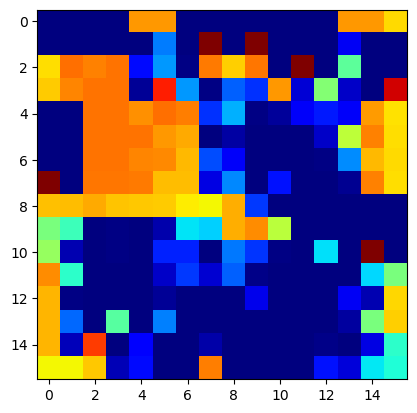

In [263]:
plt.imshow(im_out[0,:,:,0], cmap = 'jet')